In [127]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas
import math

# make this point to the file with the clean tweets
DATAFILE = "data_clean.csv"

In [94]:
# read the csv
data = pandas.read_csv(DATAFILE, index_col=0)

NAs = data["is_retweet"].isna()
rt_present = []
for i in range(len(data)):
    if NAs[i]:
        rt_present.append('rt' in data["text"])

# if no data is given, assume that 'rt' tells us
# if a tweet is a retweet or not
data["is_retweet"][data["is_retweet"].isna()] = rt_present

# verify if all the retweets have the "rt" string
all_have_rt = True
# verity if all the tweets with "rt" are retweets
all_are_retweets = True
for i in range(len(data)):
    if data["is_retweet"][i]:
        all_have_rt &= "'rt'" in data["text"][i]
    if "'rt'" in data["text"][i]:
        all_are_retweets = all_are_retweets and data["is_retweet"][i]
if all_have_rt:
    print(f"All retweets have the 'rt' string")
if all_are_retweets:
    print(f"All 'rt' tweets are retweets")

All retweets have the 'rt' string
All 'rt' tweets are retweets


In [95]:
# get all the tweets
# as of now, they are still strings, the string representation of the list
tweets = []
for tweet in data["text"]:
    tweets.append(eval(tweet))

# get the unique set of existing words and count those words
# check the most common ones
words = {}
total_words = 0
for tweet in tweets:
    for word in tweet:
        total_words += 1
        if word in words.keys():
            words[word] += 1
        else:
            words[word] = 1
print(f"We have {total_words} words, of which {len(words.keys())} are unique")
words_tuples = [(word, words[word]) for word in words.keys()]
words_tuples.sort(reverse=True, key=lambda t: t[1])

We have 60873 words, of which 7496 are unique


Text(0.5, 1.0, 'Most common tweet words')

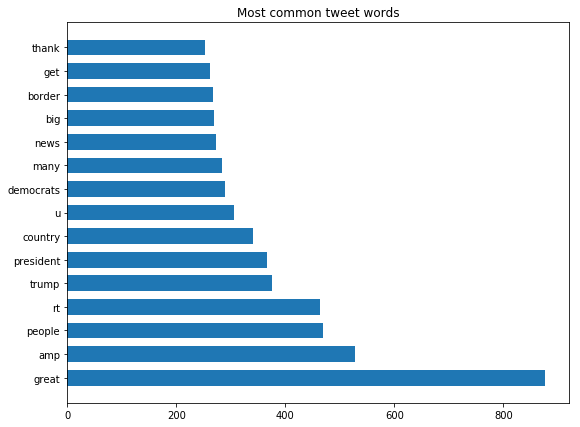

In [96]:
# plot a histogram of the N most common words
fig, ax = plt.subplots(figsize=(9,7))
N = 15
heights = [tup[1] for tup in words_tuples[:N]]
words = [tup[0] for tup in words_tuples[:N]]
indices = list(range(1, 3*N+1, 3))
bar_width = 2

ax.barh(indices, heights, bar_width)
ax.set_yticks(indices)
ax.set_yticklabels(words)
ax.set_title("Most common tweet words")

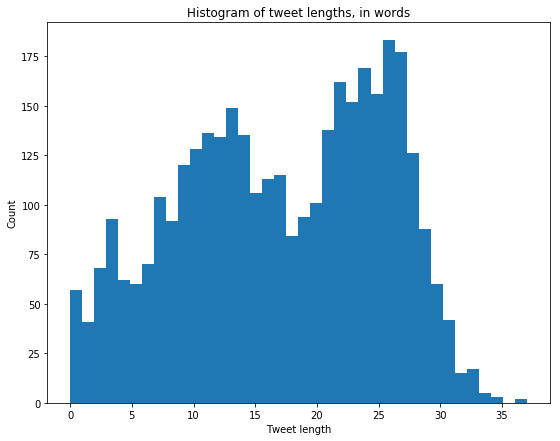

In [97]:
# plot a histogram of the number of words per tweet
lens = list(map(len, tweets))
maxsize = max(lens)

fig, ax = plt.subplots(figsize=(9,7))
ax.hist(lens, bins=maxsize+1);
ax.set_title("Histogram of tweet lengths, in words");
ax.set_xlabel("Tweet length");
ax.set_ylabel("Count");

There are 3120 words that only show up once


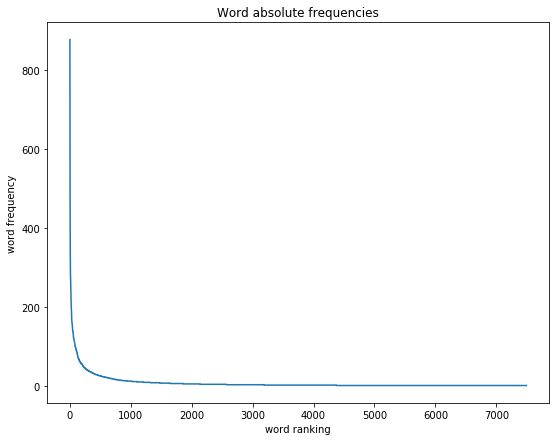

In [98]:
# check the curve of the frequencies
fig, ax = plt.subplots(figsize=(9,7))
freqs = [t[1] for t in words_tuples]
ax.plot(freqs)
ax.set_title("Word absolute frequencies")
ax.set_xlabel("word ranking")
ax.set_ylabel("word frequency")

first_one = freqs.index(1)
print(f"There are {len(freqs)-first_one} words that only show up once")

In [99]:
# check how many words make up some quantiles of the total number of words
quantiles = [0.5, 0.75, 0.9, 0.95]
# counts[i] is a pair (n, per) meaning that n words is the minimum number of
# words needed to make up for quantiles[i]% of all the words
counts = []
for q in quantiles:
    if counts:
        i = counts[-1][0]
        per = counts[-1][1]
    else:
        i = 0
        per = 0
    while per < q:
        i += 1
        per += words_tuples[i][1]/total_words
    counts.append((i, per))
for count in counts:
    print(f"{count[0]} words make up for {round(100*count[1],2)}% of all the words used")

372 words make up for 50.0% of all the words used
1303 words make up for 75.01% of all the words used
3330 words make up for 90.0% of all the words used
5329 words make up for 95.0% of all the words used


['great', 'amp', 'people', 'rt', 'trump', 'president', 'country', 'u', 'democrats', 'many']


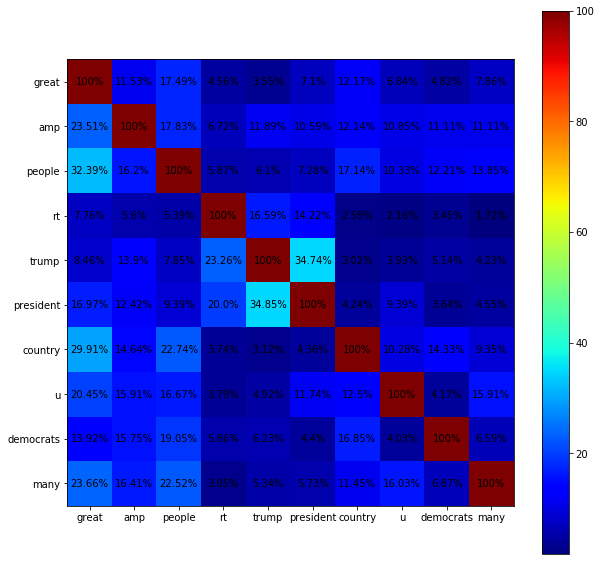

In [100]:
# take the N most common words and check how many times they show up together
N = 10
topN_words = [t[0] for t in words_tuples[:N]]
print(topN_words)
# matrix[i][j] has the percentage of tweets containing word i that also contained word j
matrix = [[0 for i in range(N)] for j in range(N)]
for j in range(N):
    base_word = topN_words[j]
    for tweet in tweets:
        if base_word in tweet:
            for i in range(j, N):
                scnd_word = topN_words[i]
                if scnd_word in tweet:
                    matrix[i][j] += 1
for j in range(N):
    for i in range(j):
        matrix[i][j] = matrix[j][i]
# at this step matrix[i][j] = matrix[j][i] only has, in (i,j), the number of times words i and j come up together
for i in range(N):
    for j in range(i+1, N):
        matrix[i][j] = round(matrix[i][j]/matrix[i][i]*100, 2)
    for j in range(i):
        matrix[i][j] = round(matrix[i][j]/matrix[i][i]*100, 2)
for i in range(N):
    matrix[i][i] = 100

# plot the matrix, code from
# https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
fig = plt.figure(figsize=(10,10))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(matrix), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = N, N

for x in range(width):
    for y in range(height):
        ax.annotate(f"{matrix[x][y]}%", xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
plt.xticks(range(width), topN_words)
plt.yticks(range(height), topN_words)
None # prevent annoying extra output

In the above "confusion matrix" we can see, for example, that $32.39\%$ of all the tweets containing the word _people_ also contained the word _great_ (as we can confirm with the next snippet) but only $17.49\%$ of the tweets with the word _great_ contained the word _people_.

In [101]:
count = 0
hits = 0
for tweet in tweets:
    if "people" in tweet:
        count += 1
        if "great" in tweet:
            hits += 1
print(hits/count)

0.323943661971831


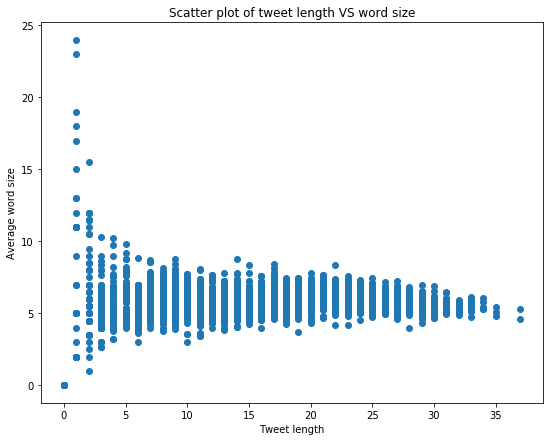

In [102]:
# check the relationship between amount of words and avg length of the words
lens = list(map(len, tweets))
avg_word_length = [sum([len(word) for word in tweets[i]])/lens[i] if lens[i] > 0 else 0 for i in range(len(lens))]

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(lens, avg_word_length)
ax.set_title("Scatter plot of tweet length VS word size");
ax.set_xlabel("Tweet length");
ax.set_ylabel("Average word size");

In [103]:
# Note that some of the tweets with only 1 long word
# actually look like they were hashtags
for tweet in tweets:
    if len(tweet) == 1 and len(tweet[0]) > 10:
        print(tweet)

['armynavygame']
['remembering41']
['interesting']
['jobsnotmobs']
['jobsnotmobs']
['jobsnotmobs']
['hurricaneflorence']
['stopthebias']
['pledgetoamericasworkers']
['vfwconvention']
['memorialday']
['peaceofficersmemorialday']
['usembassyjerusalem']
['nationaldayofprayer']
['congratulations']


In [104]:
# we also got a bunch of numbers in here
# and some single letter/2-letter words that don't look good
for word, count in words_tuples:
    if len(word) < 3:
        print(word)

rt
u
us
go
1
2
7
4
13
c
3
p
00
9
un
h
6
8
50
5
g
10
xi
17
ms
j
w
r
15
18
25
30
ig
45
12
mr
11
20
jr
40
de
60
e
dr
va
b
oh
14
16
ok
19
el
90
en
v
nc
ag
36
21
f
51
co
24
0
k
pm
n
53
l
70
sc
93
29
44
al
bi
da
ii
47
79
26
80
52
th
35
ed
49
55
64
28
48
z
lt
hq
vs
eu
33
22
iq
nh
wh
ap
75
99
32
77
la
ca
46
fo
le
ar
63
op
57
96
tr
ex
27
pa
rv
cr
ty
62
59
87
mi
gm
fu
42
54
82
41
23
2a
ks
tn
q
8x
hu
92
97
ad
mo
na
ne
68
es
si
aw
rs
wo
bo
ck
37
31
ro
69
vp
fa
ol
ny
95
vi
pe
cc
fe
91
rx
39
md
pr
2n
lc
ac
fl
uk
jw
71
66
gl


In [105]:
# turn each tweet into a vector with N coordinates
# also, tag each tweet with a unique ID
# coordinate i of tweeter n will say how many times the top word i appeared
N = 10
topN_words = [t[0] for t in words_tuples[:N]]
vector_tweets = []
newID = 0
for tweet in tweets:
    counts = [tweet.count(word) for word in topN_words]
    # use numpy arrays so that later calculations are easier
    vector_tweets.append((newID, np.array(counts, dtype=int)))
    newID += 1

In [106]:
print(vector_tweets[:3])
print(vector_tweets[-3:])

[(0, array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0])), (1, array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0])), (2, array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0]))]
[(3554, array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1])), (3555, array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])), (3556, array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))]


In [107]:
def tweet_distance(v1, v2):
    return np.linalg.norm(v1-v2)

In [122]:
# prepare a progress bar to ensure things are running and not frozen
# check http://python.6.x6.nabble.com/carriage-return-in-ipython-notebook-td4717456.html
import uuid
import time
from IPython.core.display import HTML, Javascript, display
divid = str(uuid.uuid4())

display(HTML(
"""
<div style="border: 1px solid black; width:500px">
  <div id="%s" style="background-color:blue; width:0%%">&nbsp;</div>
</div> 
""" % divid)
)

# Now that each tweet is a vector, we can cluster them
# apply the K-means algorithm
#K = math.ceil(math.sqrt(N))
K = N
# set the seed for reproducibility
random.seed(73)
# pick some random cluster centroids at the beginning
centroids = [t[1] for t in random.sample(vector_tweets, K)]
clusters = [[] for i in range(K)]
old_clusters = dict()
iteration = 0
max_iterations = 10
while iteration < max_iterations:
    display(Javascript("$('div#%s').width('%i%%')" % (divid, round(100*(1+iteration)/max_iterations))))
    # iterate over all tweets
    for tweet in vector_tweets:
        # assign the tweet to the cluster w/ closest centroid
        bestDist = 10**6
        bestCluster = -1
        for k in range(K):
            d = tweet_distance(tweet[1], centroids[k])
            if d < bestDist:
                bestCluster = k
                bestDist = d
        clusters[bestCluster].append(tweet)
        
    # check if, in this iteration, anything changed place
    # either way, store the cluster to which each tweet was assigned
    k = 0
    changes = 0
    while k < K:
        cluster = clusters[k]
        for tweet in cluster:
            if old_clusters.get(tweet[0], -1) != k:
                changes += 1
            old_clusters[tweet[0]] = k
        k += 1
    if changes/len(tweets) < 0.01:
        break
        
    # find the new centroids
    for k in range(K):
        if len(clusters[k]) == 0:
            continue
        centroid_sum = np.zeros([1, N], np.double)
        for tweet in clusters[k]:
            centroid_sum += tweet[1]
        centroids[k] = centroid_sum / len(clusters[k])
        
    iteration += 1
print(iteration)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

10


In [125]:
# take some random tweets from every cluster
for cluster in clusters:
    some_tweets = random.sample(cluster, 10)
    for idx, vec in some_tweets:
        print(data["text"][idx].replace("', '", " "))
    print("-"*40)

['rt outside trump rally las vegas thousands conservatives line extends way arou']
['rt president trump provides update response hurricane michael']
['rt anything mueller investigation tainted anti trump fbi agents']
['rt great night ohio 12th congressional district troy balderson troy loves ohio loves people']
['rt prime position defend majorities 2018 let defy history maga leadright']
['rt trump putting us back top']
['rt buy friends bad trade deals free military protection']
['rt lake okeechobee hurricane money passion rick scott called endlessly behalf th']
['rt use resources get help info emergencies call 911 receive info shelters evacuations amp storm']
['rt amazing trump rally las vegas nevada must 10 000 people trust say w']
----------------------------------------
['rt landed finland helsinki2018 amp prez putin set discuss us russian relations potus meeting']
['rt iranian harassment u warships 2015 22 2016 36 2017 14 2018 0 source']
['rt boom record high business optimism need

In [153]:
# instead of using my terrible implementation, use scikit
# in here we have everything together; we can tweak the number N of top words to be considered
N = 10
topN_words = [t[0] for t in words_tuples[:N]]
sk_vector_tweets = []
newID = 0
for tweet in tweets:
    counts = [tweet.count(word) for word in topN_words]
    # use numpy arrays so that later calculations are easier
    sk_vector_tweets.append((newID, np.array(counts, dtype=int)))
    newID += 1

mat = np.array([t[1] for t in sk_vector_tweets])
kmeans = KMeans(random_state=73).fit(mat)
sk_clusters = [[] for i in range(max(kmeans.labels_+1))]
for idx, lbl in enumerate(kmeans.labels_):
    sk_clusters[lbl].append(idx)
    
print(list(map(len, clusters)))

random.seed(52345234)
# take some random tweets from every cluster
for cluster in sk_clusters:
    some_tweet_idx = random.sample(cluster, 10)
    for idx in some_tweet_idx:
        print(data["text"][idx].replace("', '", " "))
    print("-"*40)
    
# does the last cluster only contain retweets?
# PS changing the random state of the KMeans, it looks
# 
print(all(map(lambda i: "'rt'" in data["text"][i], sk_clusters[-1])))
# it does!

[1699, 482, 360, 6211, 2051, 829, 17587, 2001, 2522, 1828]
['democrats talk action nothing fix daca great opportunity missed bad']
['secure border democrats historic level obstruction presidents fed agenda working economy growing twice rate obama nominated confirmed 68 federal judges 26 court appeals judges']
['collusion democrats russia many others fbi take server dnc still check biased facebook google twitter favor democrats real collusion']
['end democrats obstruction']
['today democrat party would rather protect criminal aliens american citizens democrats must voted office jobsnotmobs']
['thing lacking properly secure border democrats historic level obstruction senator david perdue georgia']
['law firm eventually kremlin connected sources gather info donald trump collusion real russia hillary democrats demand full investigation dan bongino looking forward new ig report']
['strzok started illegal rigged witch hunt called probe ended immediately angry conflicted democrats instead loo